# Analysis script for umbrella sampling simulations

This notebook contains analysis for the various umbrella sampling simulations involved in the path-based binding free energy calculation for BD2-DCAF16

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import red
import shutil
import subprocess

from analysis import *

In [2]:
"""Defining constants"""

temperature = 298.15 # K
boltzmann = 0.0019872041 # kcal/mol K
beta = 1.0/(boltzmann*temperature)
k_sep = 1000 # kcal/mol nm**-2
k_boresch = 100 # kcal/mol rad**2
k_rmsd = 3000 # kcal/mol nm**-2
sep_cv_max = 3.3 # nm
standard_volume = 1660 # angstroms^3
standard_volume_nm = standard_volume*0.001 # nm^3
radius_sphere = (3*standard_volume_nm/(4*np.pi))**(1.0/3.0) # radius of sphere whose volume is equal to the standard volume in nm

In [3]:
"""Equilibrium values for Boresch DOFs"""

boresch_eq = {
    'thetaA' : 1.45,
    'thetaB' : 1.45,
    'phiA' : -1.92,
    'phiB' : -1.22,
    'phiC' : 2.95 
}

## Generating triplicate average PMFs

/home/btan/Documents/BD2_DCAF16_8ov6/umbrella_sampling/separation/results/backbone_RMSD/run1/RED


Applying RED: 100%|██████████| 39/39 [00:00<00:00, 25200.72it/s]


/home/btan/Documents/BD2_DCAF16_8ov6/umbrella_sampling/separation/results/backbone_RMSD/run2/RED


Applying RED: 100%|██████████| 39/39 [00:00<00:00, 28354.63it/s]


/home/btan/Documents/BD2_DCAF16_8ov6/umbrella_sampling/separation/results/backbone_RMSD/run3/RED


Applying RED: 100%|██████████| 39/39 [00:33<00:00,  1.17it/s]


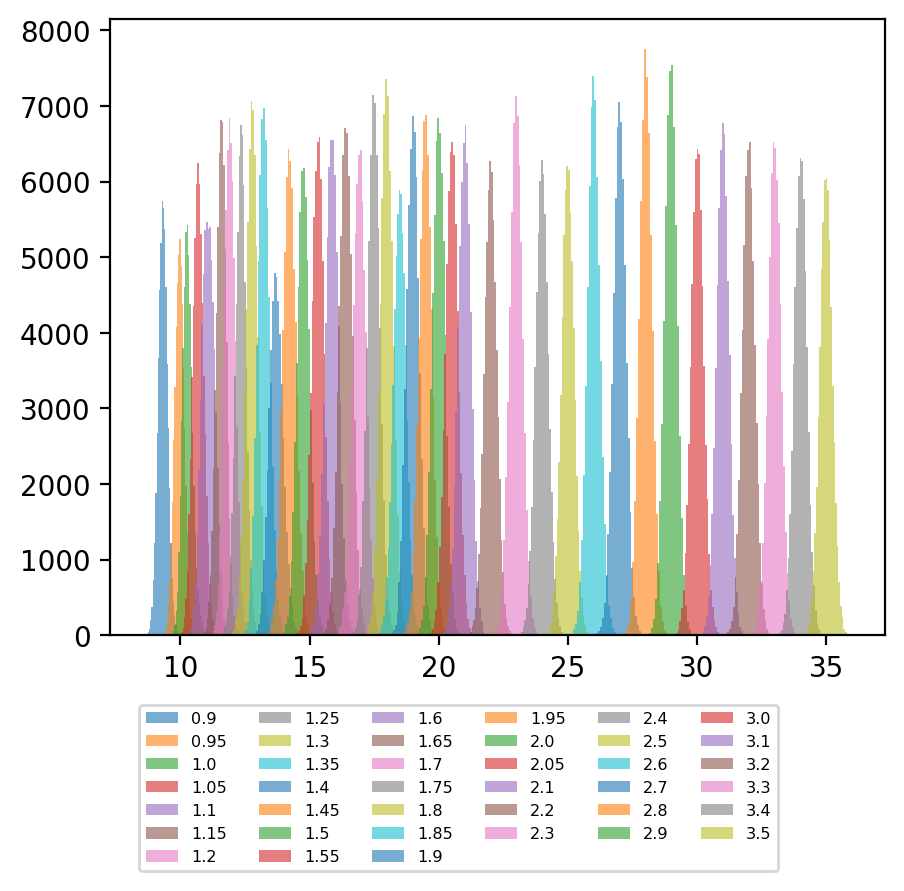

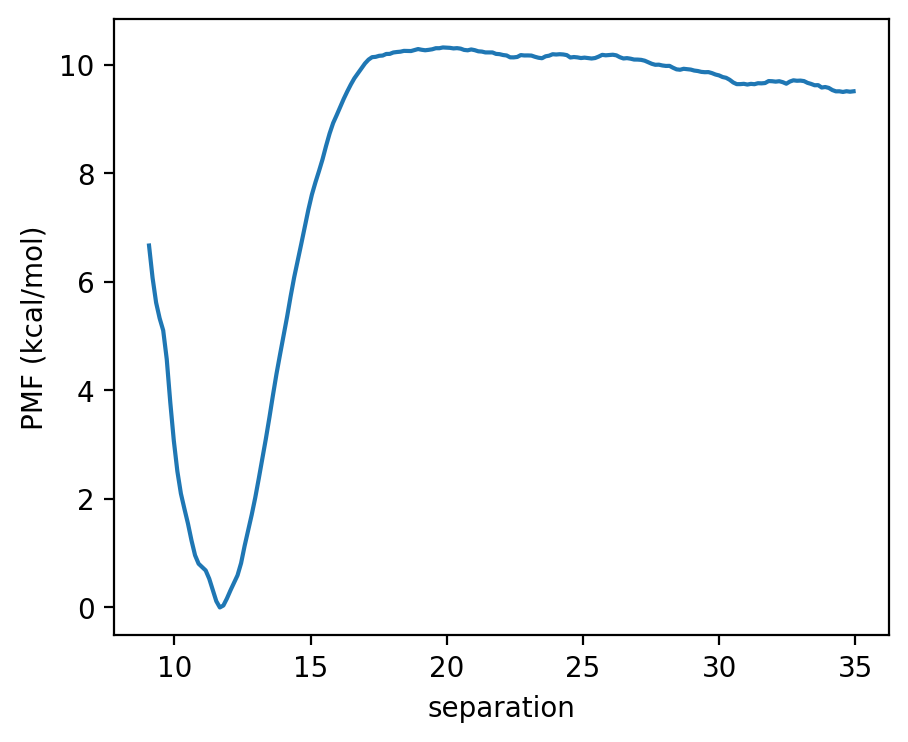

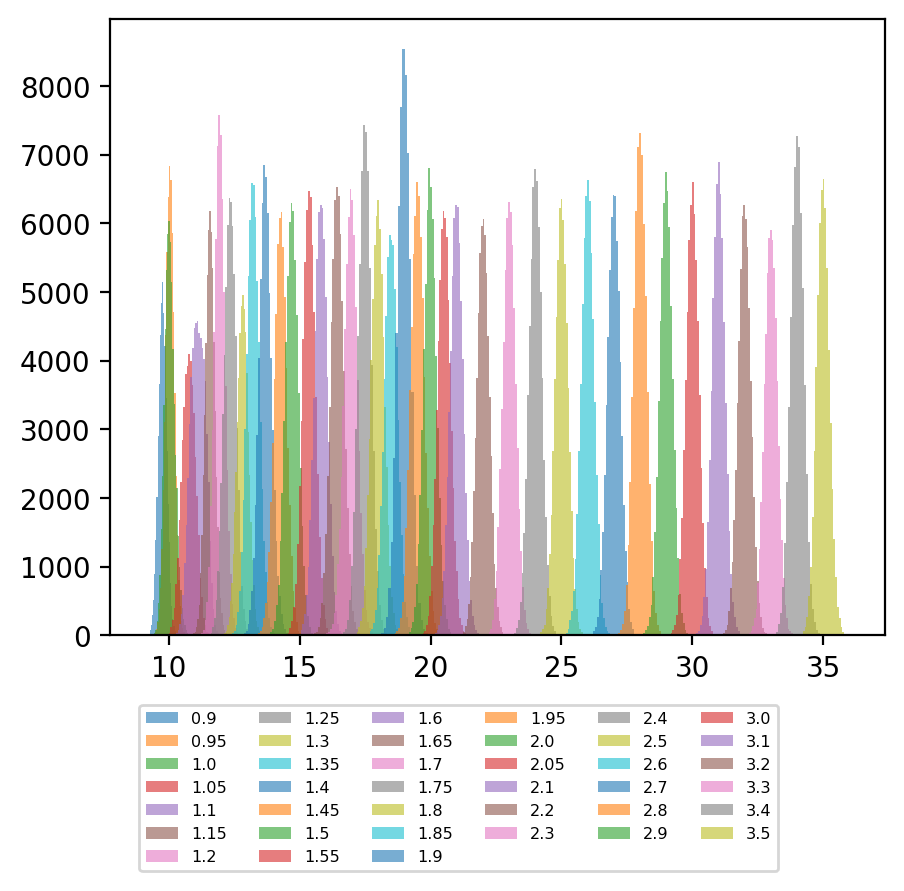

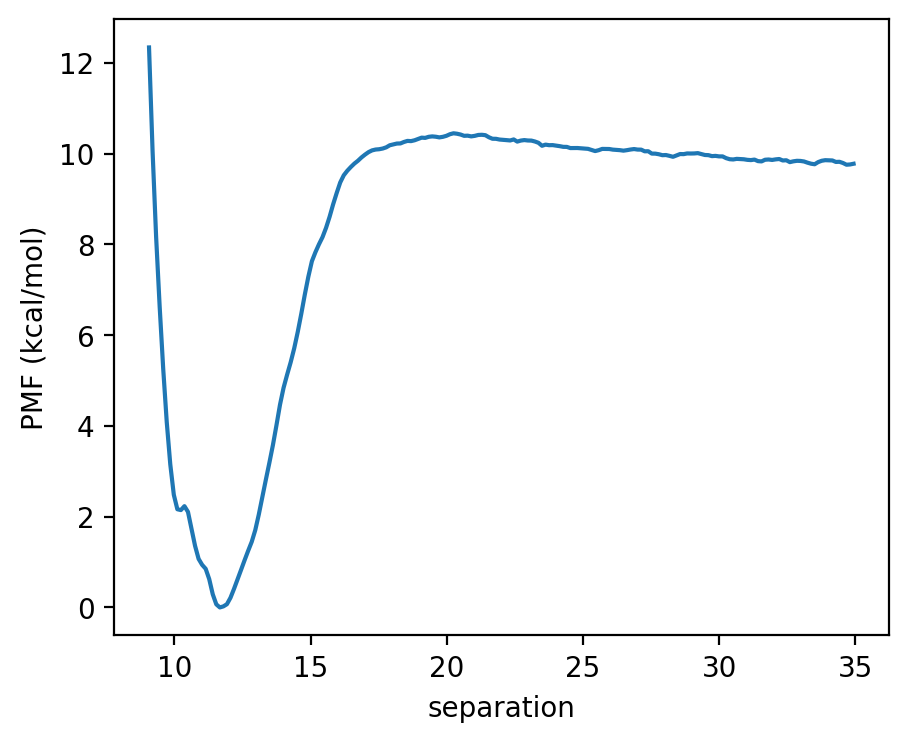

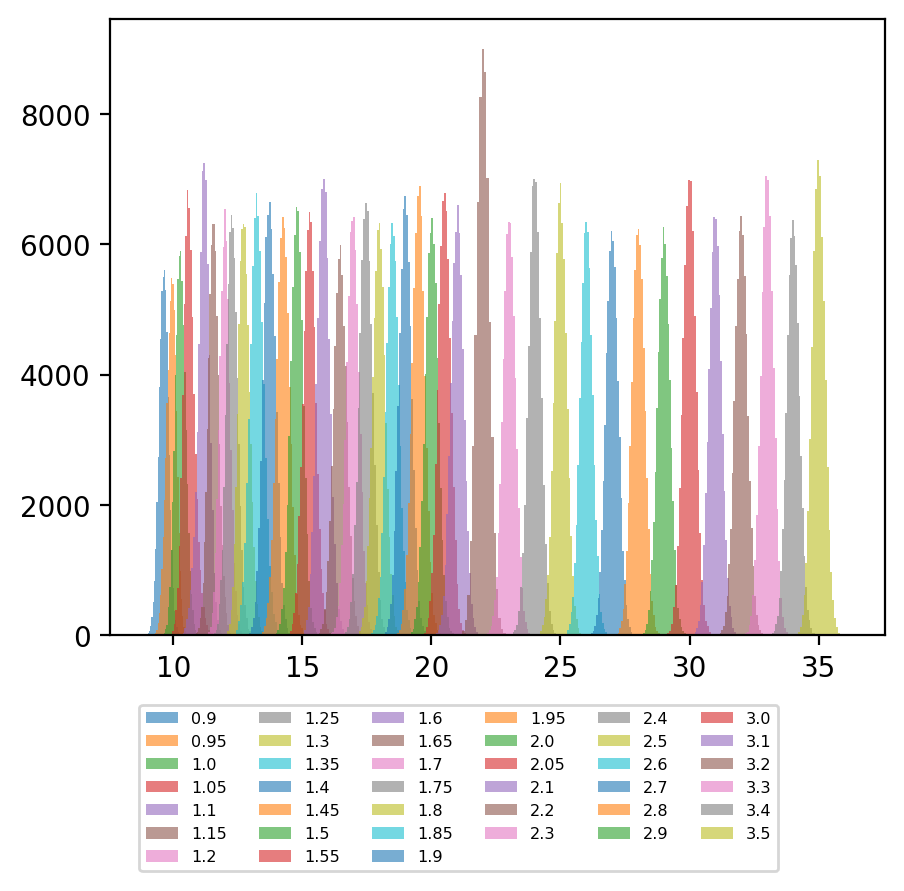

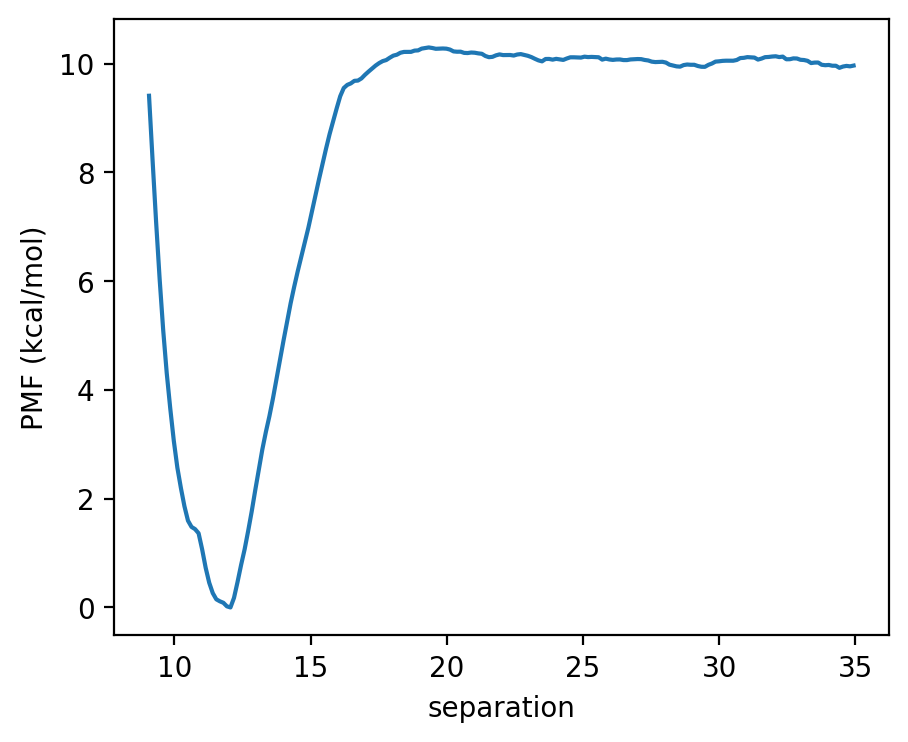

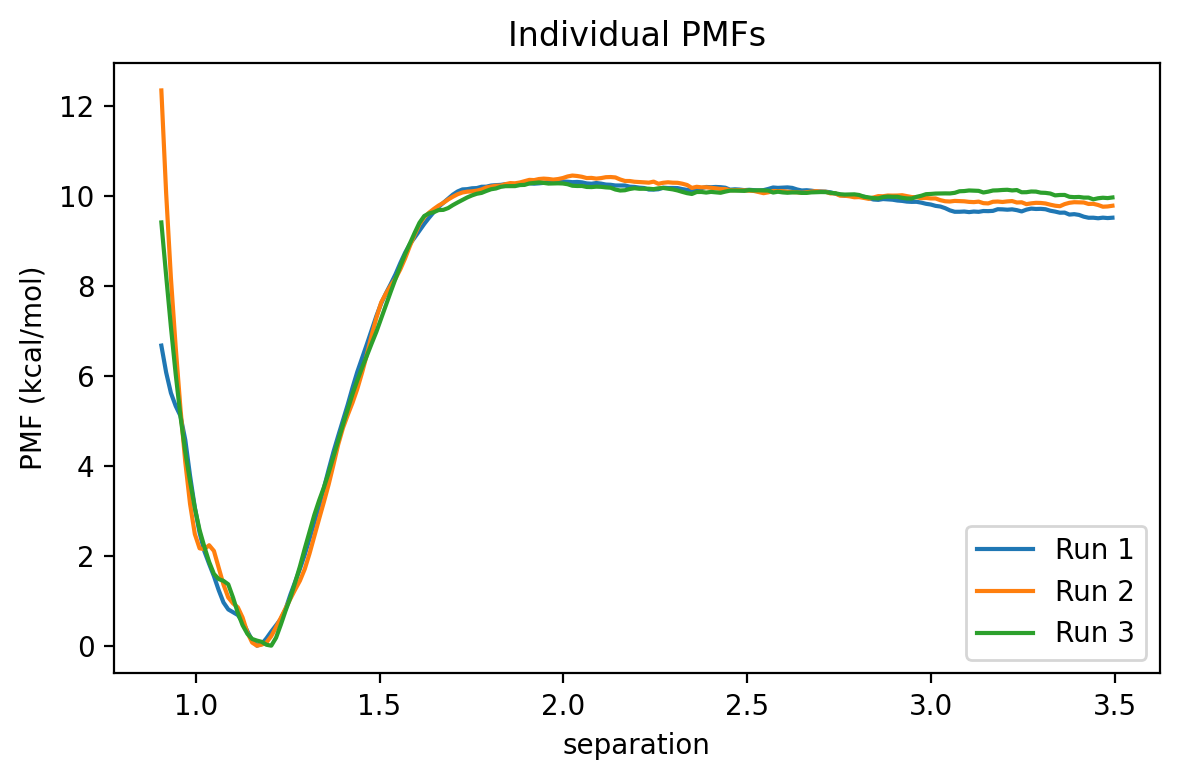

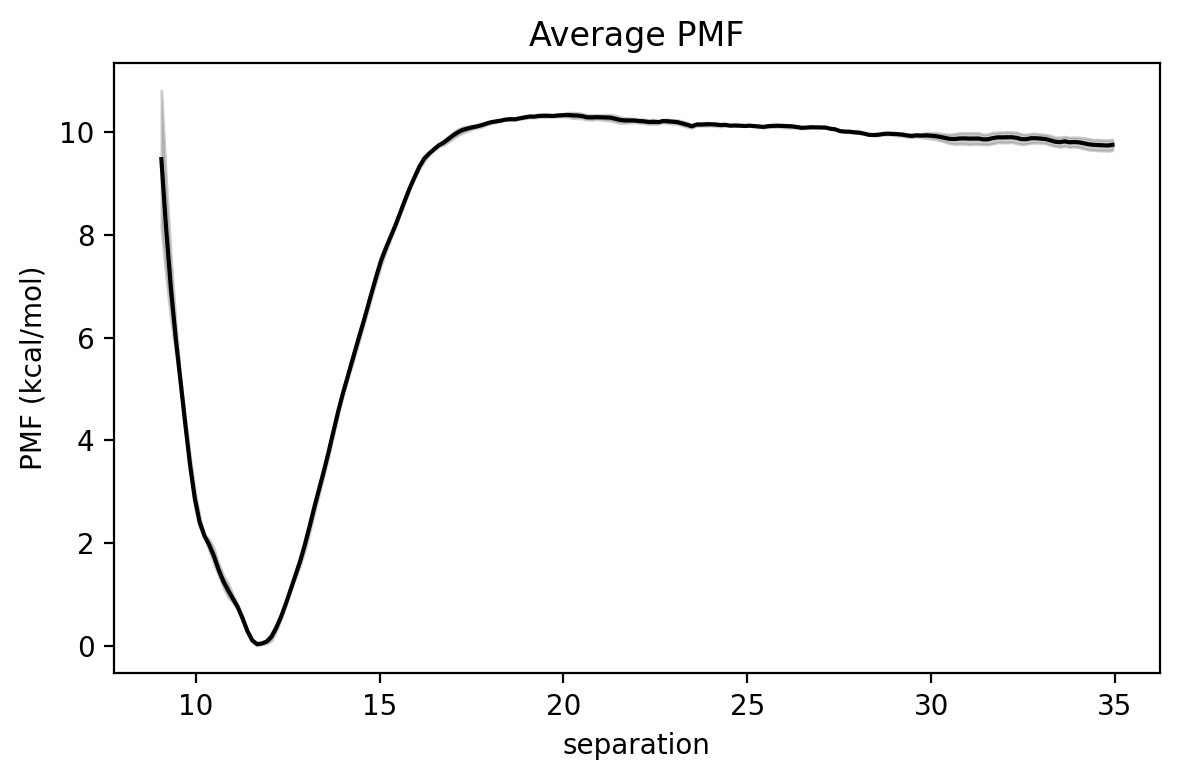

In [4]:
"""Generate the average PMF using WHAM and calculate the corresponding
free energy contribution"""

free_energies = []
r_star = sep_cv_max # sep CV max

runs = [1,2,3]

free_energy_step, restraint_type, dof, equilibration, sampling_time, plot = [
    'separation', 'backbone', 'DCAF16', 'RED', None, True
]
ignore_values = []

for run_number in runs:

    # Find upper limit for WHAM
    resultspath = obtain_dirpath(free_energy_step, restraint_type, dof, None, None, run_number)
    CV_vals = [float(filename.split('.txt')[0]) for filename in os.listdir(resultspath) if filename.endswith('.txt') and filename not in ('pmf.txt', 'metafile.txt')]
    upper_limit = np.max(CV_vals)
    lower_limit = np.min(CV_vals)

    # Convert to nm if needed
    if free_energy_step == 'RMSD':
        upper_limit = np.round(upper_limit*0.1, 5)
        lower_limit = np.round(lower_limit*0.1, 5)

    wham_params = [lower_limit, upper_limit, 200, 1e-6, 300, 0]

    if dof in ['BD2', 'DCAF16']:
        unbound = True
    else:
        unbound = False

    # Set force constant for WHAM metafile, units are kcal mol-1 / nm^2
    if free_energy_step == 'separation':
        k = k_sep
    elif free_energy_step == 'RMSD':
        k = k_rmsd
    elif free_energy_step == 'Boresch':
        k =k_boresch

    generate_metafile(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, k, ignore_values, plot)
    perform_WHAM(wham_params, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)
    x,pmf = obtain_PMF(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, plot=plot)

    if free_energy_step == 'separation':
        deltaG = SepContribution(x, pmf, r_star)
    elif free_energy_step == 'RMSD':
        deltaG = RMSDContribution(x, pmf, k, unbound)
    elif free_energy_step == 'Boresch':
        deltaG = BoreschContribution(x, pmf, boresch_eq[dof], k)

    free_energies.append(deltaG)

x, av, err = obtain_av_PMF(runs, free_energy_step, restraint_type, dof, equilibration, sampling_time, plot_indiv=True, plot_av=True)

### Analysing the CV samples for a specific window

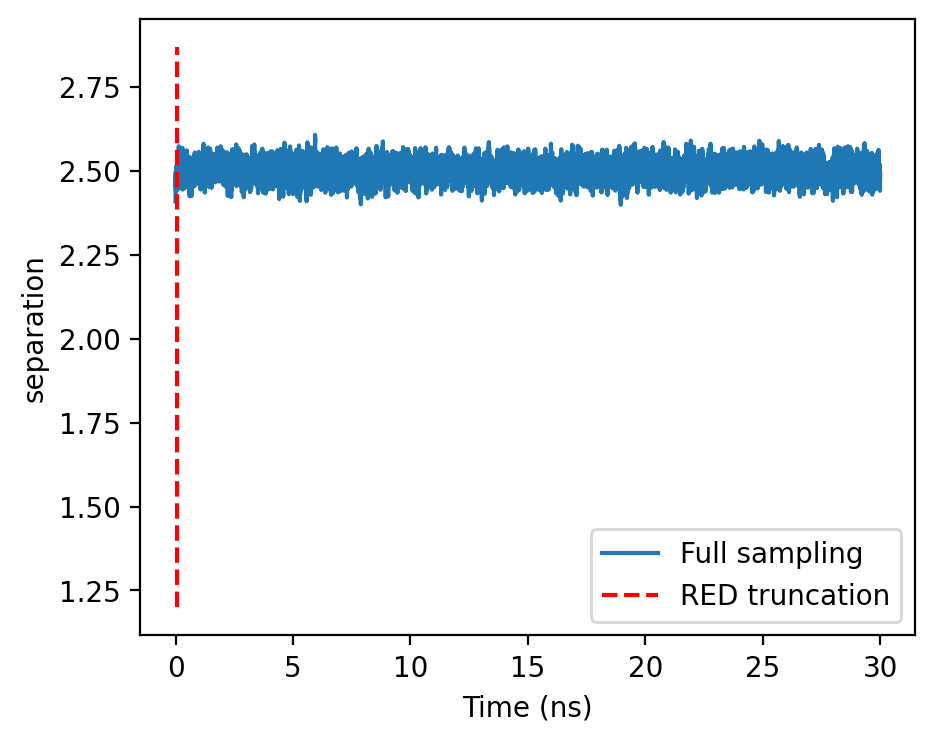

In [15]:
r0 = 2.5
run_number = 2

free_energy_step, restraint_type, dof, equilibration, sampling_time = [
    'separation', 'backbone', None, 'RED', None ]

x, y = plot_timeseries(r0, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)

### Checking the RMSD during a specific window

<Axes: xlabel='Steps'>

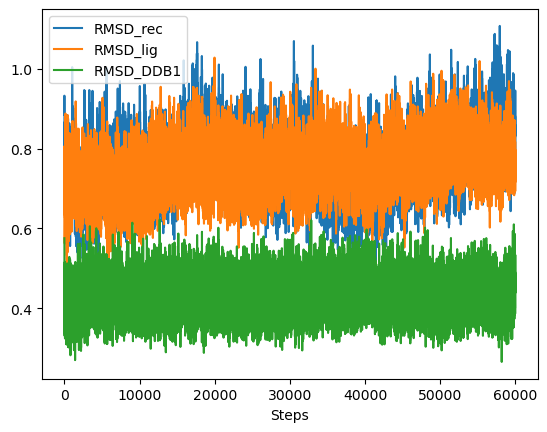

In [16]:
r0 = 2.5
run_number = 2

free_energy_step, restraint_type, dof, equilibration, sampling_time = [
    'separation', 'backbone', None, None, None ]

dirpath = obtain_dirpath(free_energy_step, restraint_type, dof, 
        equilibration, sampling_time, run_number)

df_RMSD = pd.read_csv(f'{dirpath}/{r0}_RMSD.csv')
df_RMSD.plot(x='Steps', y=['RMSD_rec', 'RMSD_lig', 'RMSD_DDB1'], legend=True)

## Calculating free energies

Calculate the free energy contributions from the various stages of the thermodynamic cycle (https://pubs.acs.org/doi/10.1021/acs.jcim.7b00695)

In [7]:
"""Separation"""

free_energies = []
r_star = sep_cv_max

runs = [1,2,3]

free_energy_step, restraint_type, dof, equilibration, sampling_time = [
    'separation', 'backbone', None, 'RED', None
]

ignore_values = [3.5]

for run_number in runs:

    wham_params = [0.0, 3.4, 200, 1e-6, 300, 0]

    k = k_sep

    generate_metafile(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, k, ignore_values, plot)
    perform_WHAM(wham_params, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)
    x,pmf = obtain_PMF(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, plot=plot)

    deltaG = SepContribution(x, pmf, r_star)

    free_energies.append(deltaG)

# Calculate average and standard error
free_energies = np.array(free_energies)
deltaG_sep = np.average(free_energies)
err_sep = np.std(free_energies)/np.sqrt(len(free_energies))

print(f"\nThe average separation free energy change is {deltaG_sep} kcal/mol")
print(f"The standard error is {err_sep} kcal/mol\n")


Applying RED: 100%|██████████| 39/39 [00:00<00:00, 94499.05it/s]



The average separation free energy change is -14.634810345878208 kcal/mol
The standard error is 0.6939177455452078 kcal/mol



In [12]:
"""RMSD"""

runs = [1,2,3]

# Select which protein to restrain first in the bound state
first_bulk_restraint = 'DCAF16'

deltaG_RMSD = 0
err_values = []

if first_bulk_restraint == 'BD2':
    systems = ['BD2', 'DCAF16', 'BD2_only', 'DCAF16withBD2']
elif first_bulk_restraint == 'DCAF16':
    systems = ['BD2', 'DCAF16', 'DCAF16_only', 'BD2withDCAF16']

# Sum all 
for system in systems:

    free_energies = []

    for n_run in runs:

        ignore_values = []

        free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number = [
            'RMSD', 'backbone', system, 'RED', None, n_run
        ]

        # Find upper limit for WHAM
        resultspath = obtain_dirpath(free_energy_step, restraint_type, dof, None, None, n_run)
        CV_vals = [float(filename.split('.txt')[0]) for filename in os.listdir(resultspath) if filename.endswith('.txt') and filename not in ('pmf.txt', 'metafile.txt')]
        upper_limit = 0.1 * np.max(CV_vals) # Convert to nm

        wham_params = [0.0, np.round(upper_limit, 6), 200, 1e-6, 300, 0]

        k = k_rmsd # Force constant
        if dof in ['DCAF16', 'BD2']:
            unbound = True
        else:
            unbound = False

        generate_metafile(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, k, ignore_values, False)
        perform_WHAM(wham_params, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)
        x,pmf = obtain_PMF(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, False)

        deltaG = RMSDContribution(x, pmf, k, unbound)
        free_energies.append(deltaG)

    free_energies = np.array(free_energies)
    deltaG_RMSD += np.average(free_energies)
    err_values.append(np.std(free_energies)/np.sqrt(len(free_energies)))

    print(f"\n{system}: ΔG = {np.round(np.average(free_energies),3)} ± {np.round(np.average(np.std(free_energies)/np.sqrt(len(free_energies))),3)} kcal/mol\n")

# Combine errors
err_values = np.array(err_values)
err_RMSD = np.sqrt(np.sum(np.square(err_values)))

print(f"\nThe average RMSD free energy change ({first_bulk_restraint} restrained first) is {deltaG_RMSD} kcal/mol")
print(f"The standard error is {err_RMSD} kcal/mol\n")


Applying RED: 100%|██████████| 16/16 [00:00<00:00, 20919.22it/s]


Applying RED: 100%|██████████| 15/15 [00:00<00:00, 21702.16it/s]



BD2: ΔG = 12.981 ± 0.052 kcal/mol



Applying RED: 100%|██████████| 15/15 [00:00<00:00, 30045.16it/s]



DCAF16: ΔG = 16.021 ± 0.278 kcal/mol



Applying RED: 100%|██████████| 15/15 [00:00<00:00, 67432.54it/s]



DCAF16_only: ΔG = -14.172 ± 0.397 kcal/mol



Applying RED: 100%|██████████| 15/15 [00:00<00:00, 25045.61it/s]



BD2withDCAF16: ΔG = -11.521 ± 0.144 kcal/mol


The average RMSD free energy change (DCAF16 restrained first) is 3.309482965571396 kcal/mol
The standard error is 0.5081422498347179 kcal/mol



In [13]:
"""Boresch"""

runs = [1,2,3]

deltaG_Boresch = 0
err_values = []

dofs = ['thetaA', 'thetaB', 'phiA', 'phiB', 'phiC']

free_energy_step, restraint_type, equilibration, sampling_time, run_number = [
    'Boresch', 'backbone', None, None, n_run
]

# Sum all 
for dof in dofs:

    free_energies = []

    for run_number in runs:

        # Find limits for WHAM
        resultspath = obtain_dirpath(free_energy_step, restraint_type, dof, None, None, run_number)
        CV_vals = [float(filename.split('.txt')[0]) for filename in os.listdir(resultspath) if filename.endswith('.txt') and filename not in ('pmf.txt', 'metafile.txt')]
        upper_limit = np.max(CV_vals)
        lower_limit = np.min(CV_vals)

        wham_params = [np.round(lower_limit, 6), np.round(upper_limit, 6), 200, 1e-6, 300, 0]

        k = k_boresch # Force constant

        generate_metafile(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, k, ignore_values, False)
        perform_WHAM(wham_params, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)
        x,pmf = obtain_PMF(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, False)

        deltaG = BoreschContribution(x, pmf, boresch_eq[dof], k)
        free_energies.append(deltaG)

    free_energies = np.array(free_energies)
    deltaG_Boresch += np.average(free_energies)
    err_values.append(np.std(free_energies)/np.sqrt(len(free_energies)))

    print(f"\n{dof}: ΔG = {np.round(np.average(free_energies),5)} ± {np.round(np.average(np.std(free_energies)/np.sqrt(len(free_energies))),8)} kcal/mol\n")

# Combine errors
err_values = np.array(err_values)
err_Boresch = np.sqrt(np.sum(np.square(err_values)))

print(f"\nThe average Boresch free energy change is {deltaG_Boresch} kcal/mol")
print(f"The standard error is {err_Boresch} kcal/mol\n")


thetaA: ΔG = -0.08182 ± 0.00478803 kcal/mol


thetaB: ΔG = -0.13409 ± 0.01621263 kcal/mol


phiA: ΔG = -0.25149 ± 0.01912651 kcal/mol


phiB: ΔG = -1.58819 ± 0.09784142 kcal/mol


phiC: ΔG = -0.2822 ± 0.00940416 kcal/mol


The average Boresch free energy change is -2.337786770385659 kcal/mol
The standard error is 0.10155283937365203 kcal/mol



In [14]:
"""Standard state correction"""

r_star = sep_cv_max
deltaG_corr = standard_state_correction(r_star, boresch_eq['thetaA'], boresch_eq['thetaB'], k_boresch)
print(f"The standard state correction is {deltaG_corr} kcal/mol")

The standard state correction is 7.190664943164137 kcal/mol


Combining all the free energy contributions:

In [15]:
"""Binding free energy"""
deltaG_bind = deltaG_RMSD + deltaG_Boresch + deltaG_sep + deltaG_corr
final_error = np.sqrt(np.sum(np.array([err_RMSD+err_Boresch+err_sep])))

print(f"Binding free energy = {deltaG_bind} kcal/mol")
print(f"The standard error is {final_error} kcal/mol")

Binding free energy = -6.472449207528333 kcal/mol
The standard error is 1.1417586587162707 kcal/mol


# Equilibration and bias

#### Calculating the average plateau height and error for different equilibration times

In [ ]:
# plateau_values = []
# plateau_errors = []

# sampling_time = 20
# eq_times = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# x, av, err = obtain_av_PMF('separation', 'backbone', None, 'RED', sampling_time, plot_av=False)
# plateau_RED, err_RED = obtain_av_plateau(x, av, err)

# for eq_time in eq_times:

#     print(f"\nPlateau analysis for {eq_time} ns equilibration\n")

#     # Generate metafile and perform WHAM
#     for run_number in [1,2,3]:
#         generate_metafile('separation', 'backbone', None, eq_time, sampling_time, run_number, 1000, ignore_values=[3.9,4.0], plot=False)
#         wham_params = [0.0, 3.8, 200, 1e-6, 300, 0]
#         perform_WHAM(wham_params, 'separation', 'backbone', None, eq_time, sampling_time, run_number)
        
#     x, av, err = obtain_av_PMF('separation', 'backbone', None, eq_time, sampling_time, plot_av=False)
#     plateau, err = obtain_av_plateau(x, av, err, plateau_bounds=[2.5, 3.2])

#     plateau_values.append(plateau)
#     plateau_errors.append(err)

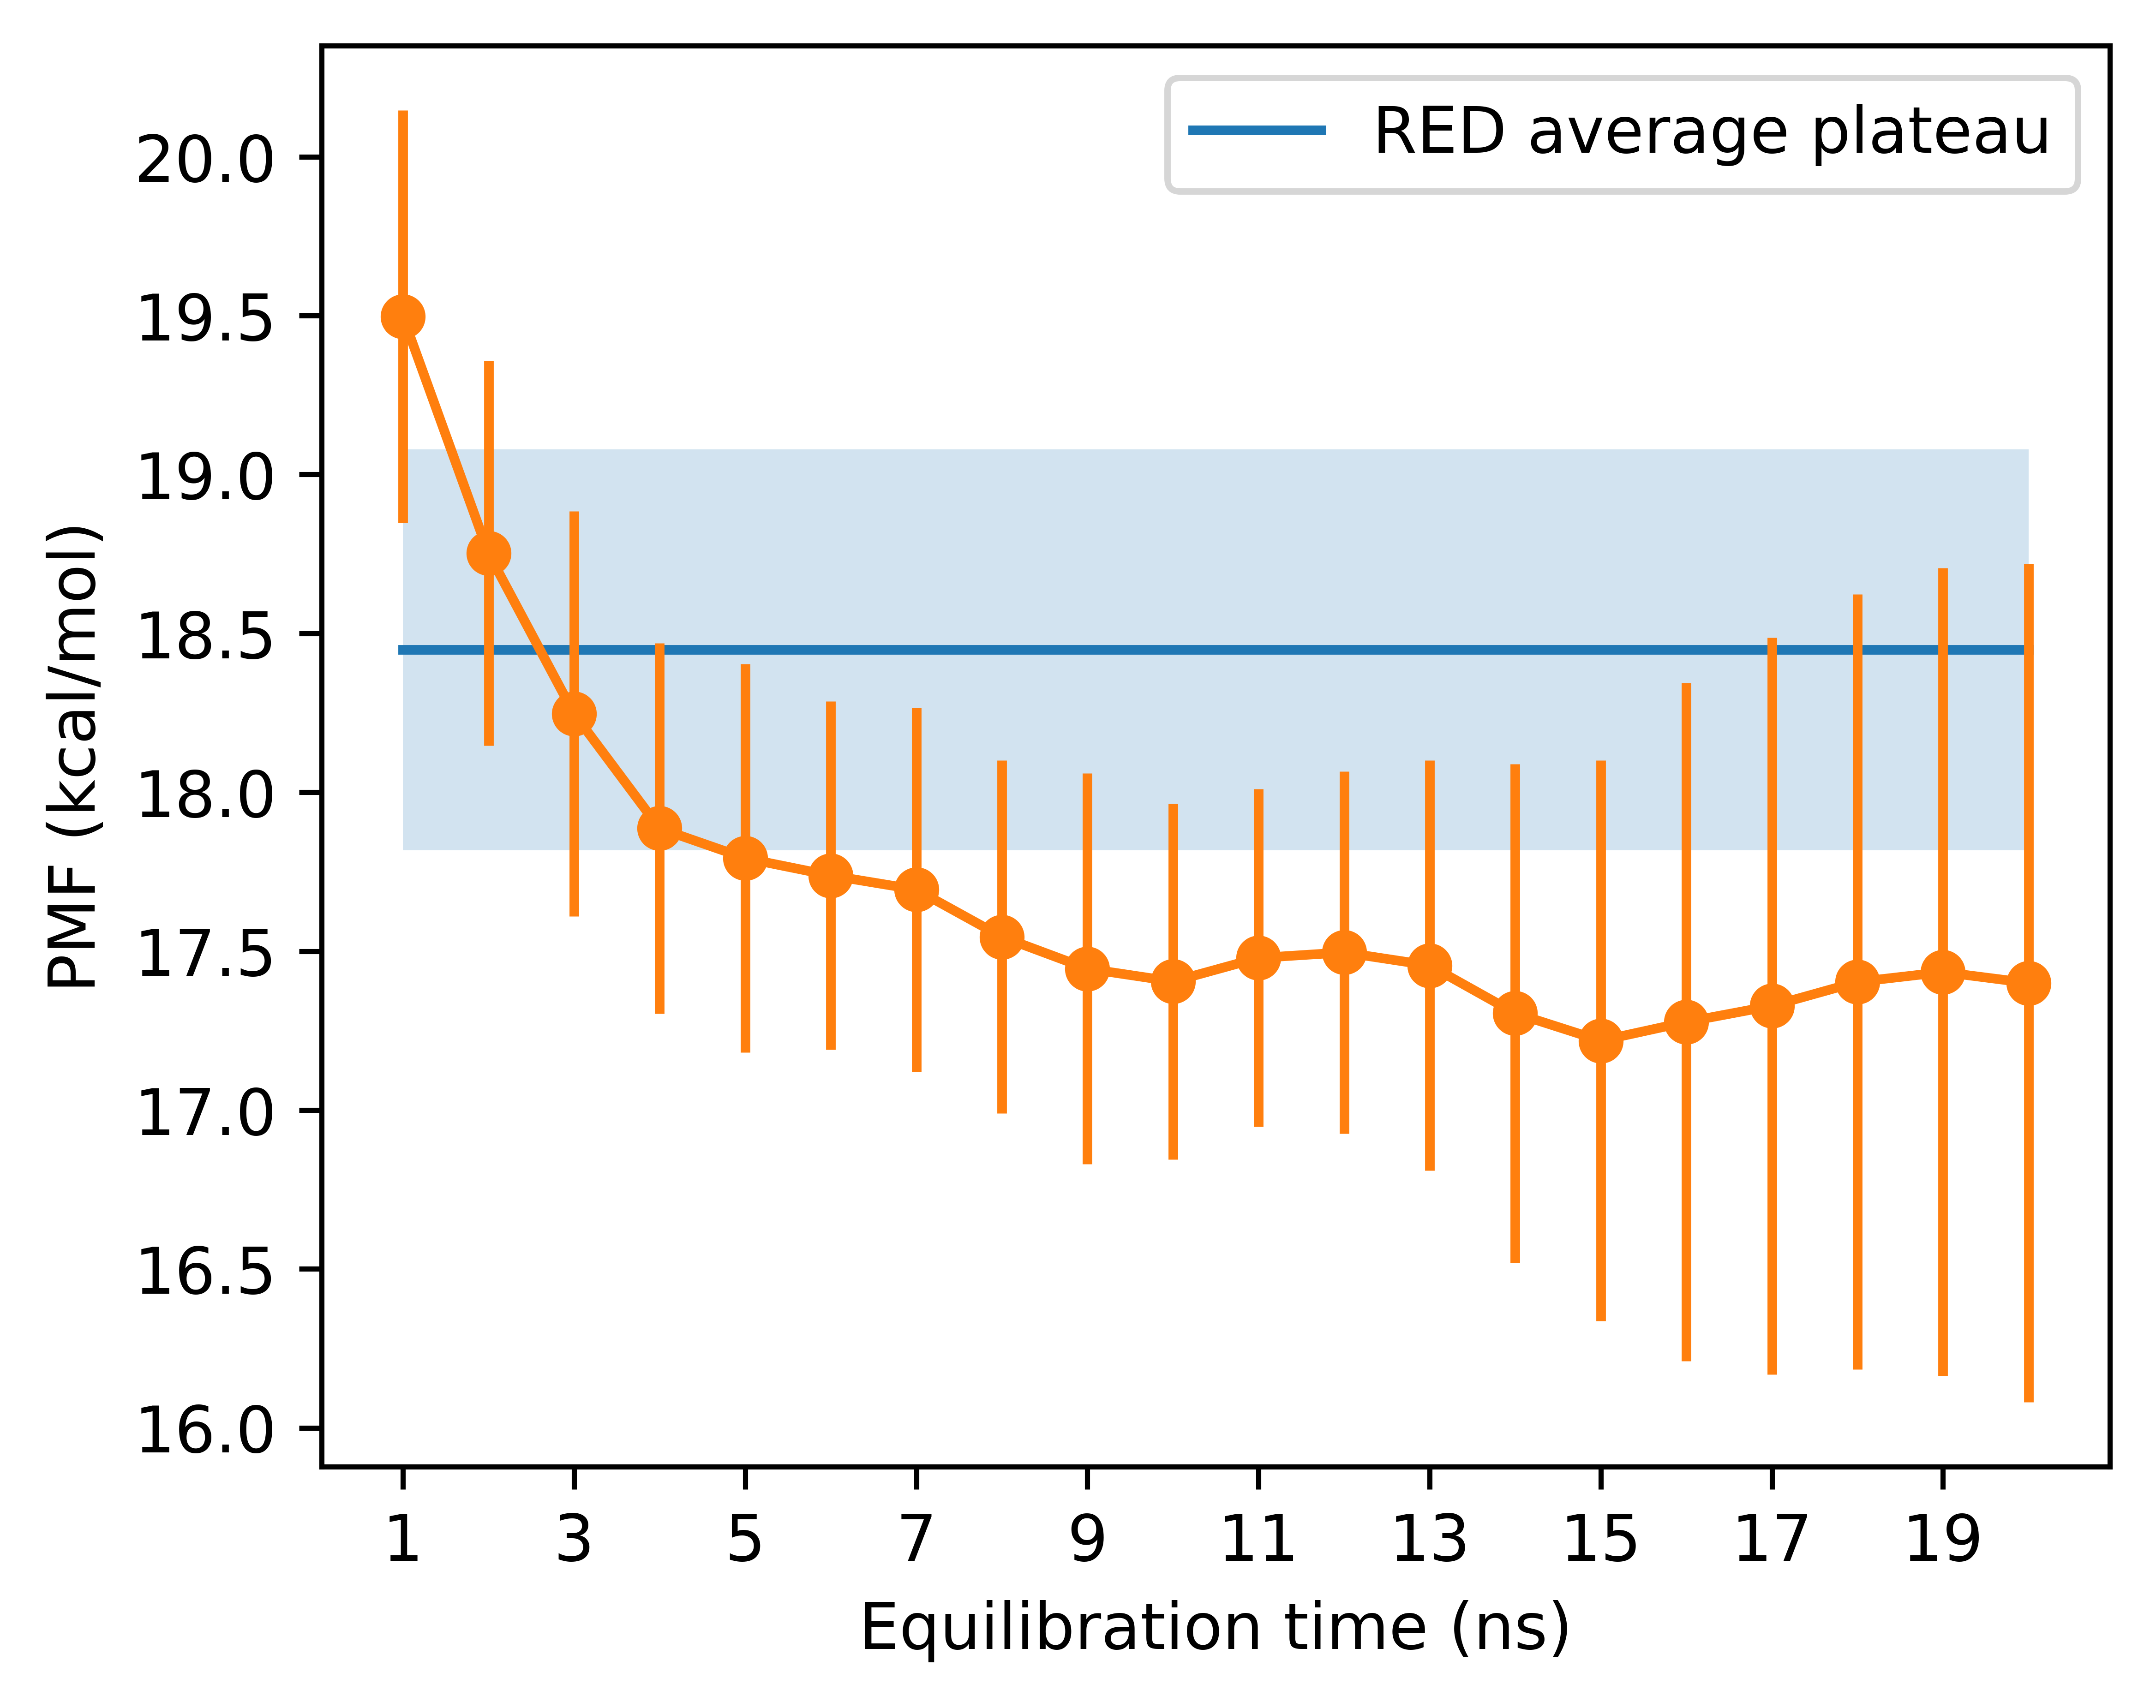

In [ ]:
# x = eq_times
# x_label = np.arange(1,len(eq_times)+1,2)

# plt.figure(figsize=(5,4), dpi=1000)
# plt.plot(x, plateau_RED*np.ones(len(x)), label='RED average plateau')
# plt.fill_between(x, (plateau_RED-err_RED)*np.ones(len(x)), (plateau_RED+err_RED)*np.ones(len(x)), alpha=0.2)
# plt.errorbar(x, plateau_values, plateau_errors, marker='o') 
# plt.xticks(x_label)
# plt.xlabel('Equilibration time (ns)')
# plt.ylabel('PMF (kcal/mol)')
# plt.legend()
# plt.show()

Plotting PMFs: 

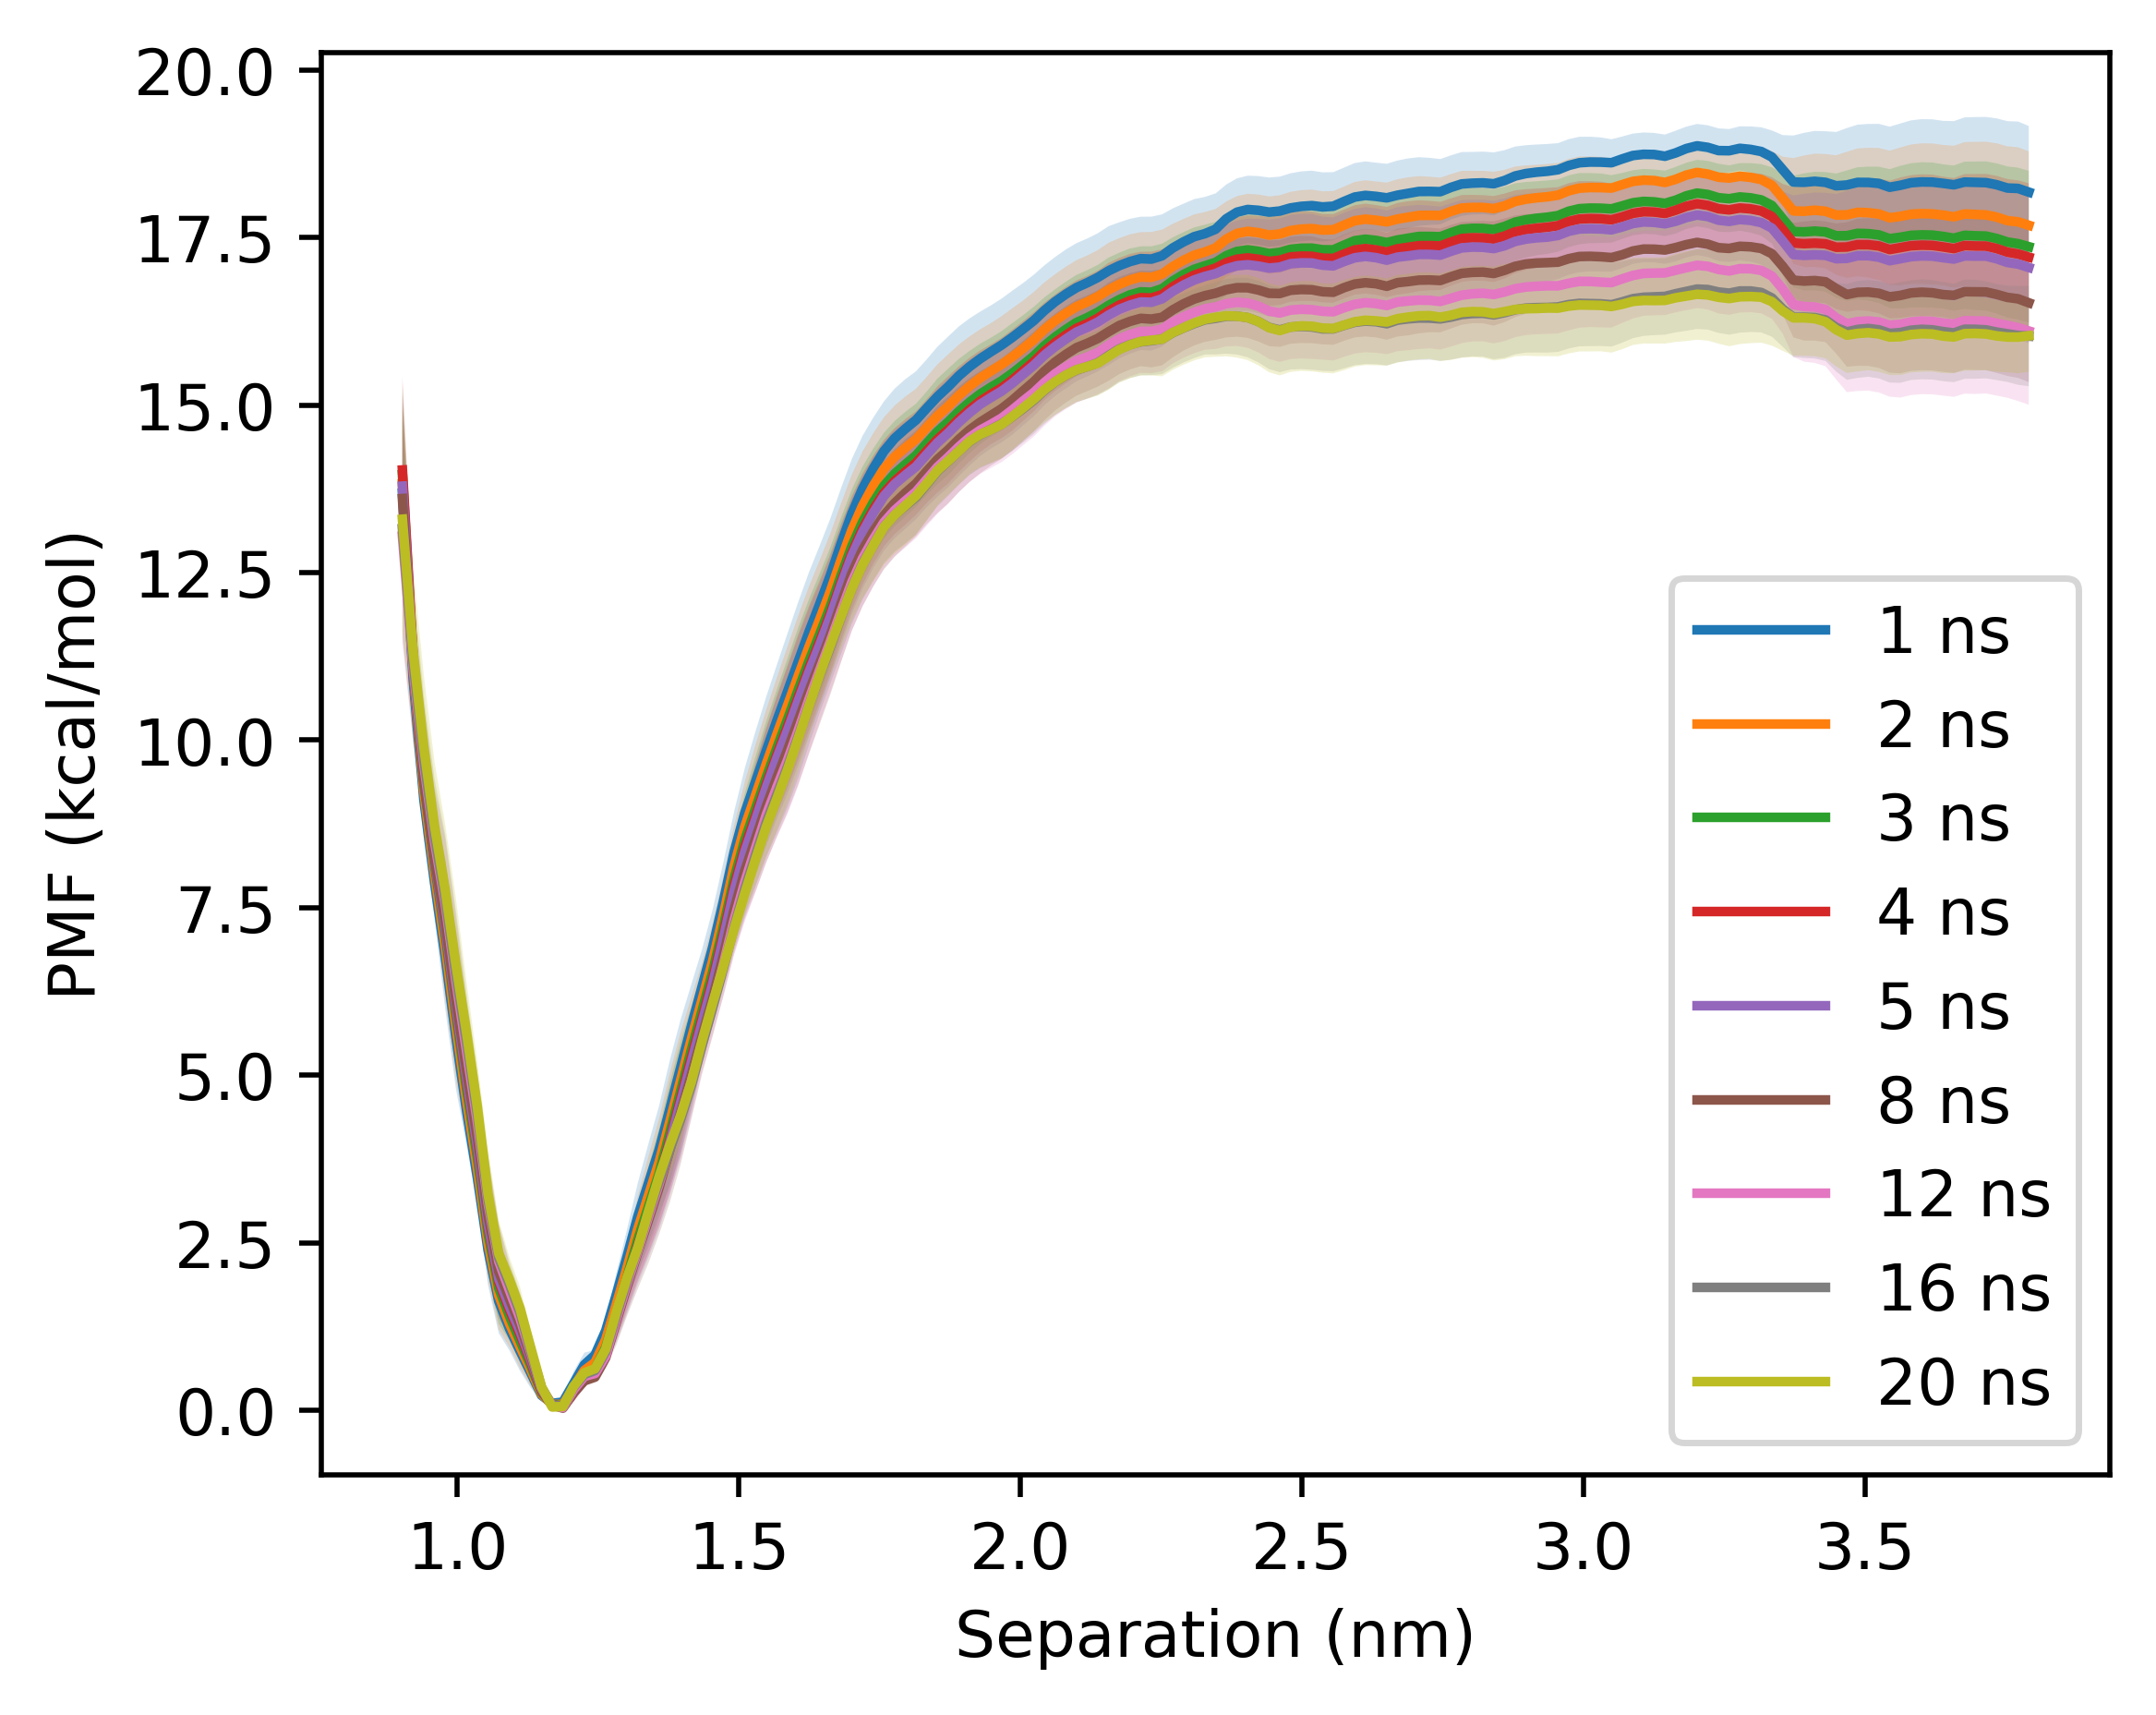

In [ ]:
# plt.figure(figsize=(5,4), dpi=500)
# eq_times = [1, 2, 3, 4, 5, 8, 12, 16, 20]
# sampling_time = 40

# for eq_time in eq_times:

#     x, av, err = obtain_av_PMF('separation', 'backbone', None, eq_time, sampling_time, plot_av=False)
    
#     plt.plot(x, av, label=f"{eq_time} ns")
#     plt.fill_between(x, av-err, av+err, alpha=0.2)

# plt.legend()
# plt.xlabel('Separation (nm)')
# plt.ylabel('PMF (kcal/mol)')
# plt.legend()
# plt.show()

### Performing analysis with increasing sampling time

In [ ]:
# plateau_values = []
# plateau_errors = []
# eq_time = 10

# sampling_times = [4, 6 ,8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 
#         28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]

# for sampling_time in sampling_times:

# #     print(f"\nPlateau analysis for {sampling_time} ns sampling\n")

#     # Generate metafile and perform WHAM
#     # for run_number in [1,2,3]:
#     #     generate_metafile('separation', 'backbone', None, eq_time, sampling_time, run_number, 1000, ignore_values=[3.9,4.0], plot=False)
#     #     wham_params = [0.0, 3.8, 200, 1e-6, 300, 0]
#     #     perform_WHAM(wham_params, 'separation', 'backbone', None, eq_time, sampling_time, run_number)
        
#     x, av, err = obtain_av_PMF('separation', 'backbone', None, eq_time, sampling_time, plot_av=False)
#     plateau, err = obtain_av_plateau(x, av, err, plateau_bounds=[2.5,3.2])

#     plateau_values.append(plateau)
#     plateau_errors.append(err)

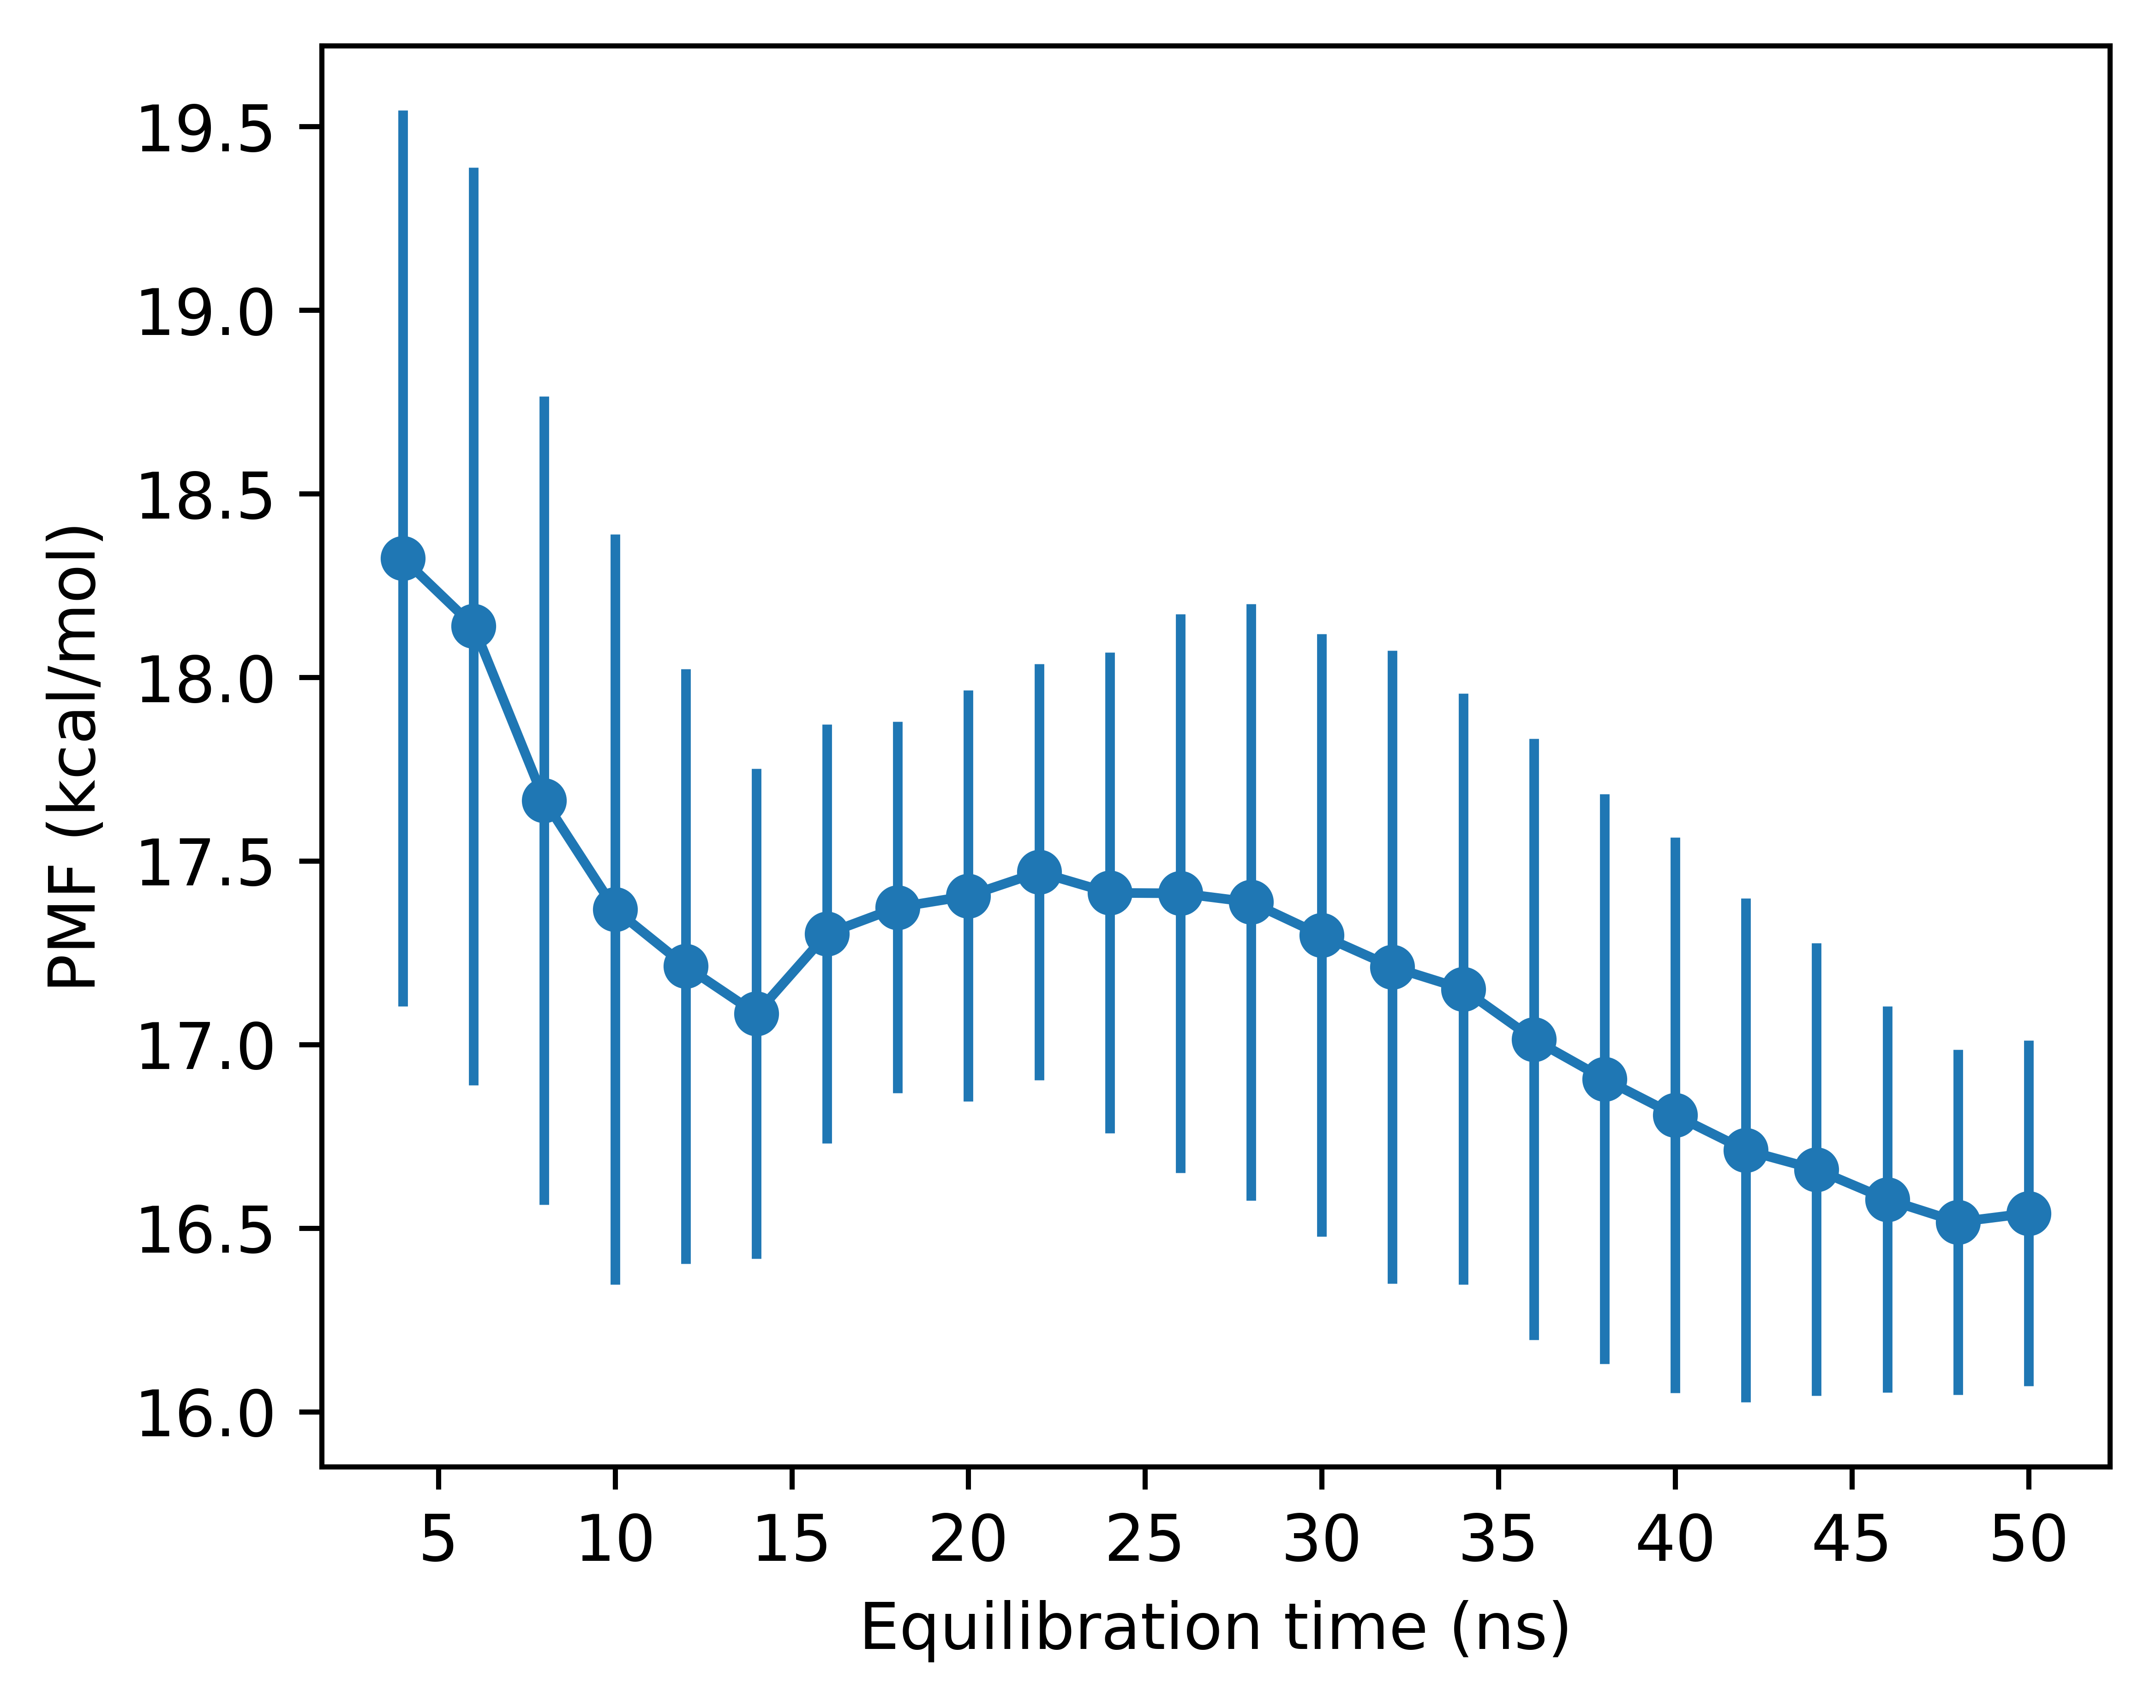

In [ ]:
# plt.figure(figsize=(5,4), dpi=1000)
# plt.errorbar(sampling_times, plateau_values, plateau_errors, marker='o') 
# plt.xticks(np.arange(5, 51, 5))
# plt.xlabel('Equilibration time (ns)')
# plt.ylabel('PMF (kcal/mol)')
# plt.show()